In [1]:
# !pip3 install talos
# !pip3 install --upgrade --no-deps --force-reinstall git+https://github.com/autonomio/talos
# !pip3 install Keras
# !pip3 install kerasplotlib --no-deps
# !pip3 install wrangle --no-deps

In [2]:
# Basic libs
import array as array
import glob
import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime, timedelta
from pathlib import Path
from pandas.plotting import scatter_matrix

# Plot libs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.patches as patches

# Model libs
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import LSTM as LSTM_keras
from numpy.random import seed
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json

# Optimization Lib
import keras.metrics as metrics
from talos import Scan, Reporting
from os import listdir

# To get reproducible results:
seed_value = 1
import os

## Initialize the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Libs to set the random value 
import random
import numpy as np
import tensorflow as tf

In [3]:
# Number of minutes to aggregate the data
MINUTES = 1

# Where the test data start
TEST_INIT_DATE = datetime(2020, 12, 1).date()

# Size of the look back
LOOK_BACK = 12

# The csv station ("santa_elena" or "hawkesworth_bridge")
STATION = "santa_elena"

# Factor to multiply by MAPE in classification step
FACTOR = 1

## Reproducible Results

In [4]:
# Set the random state to "1" to get reproducible results
def reset_random_seeds():
    
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ["PYTHONHASHSEED"] = str(1)
    
    # 2. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(1)
    
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(1)
    
    # 4. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(1)

## Pre-Processing

In [5]:
# Combines the csvs creating a DataFrame with all data (regression)
def read_data(path):
    df_all = None

    # Show all csv ending with _wtlv1 in all dirs inside this path
    for f in Path(path).rglob('*_wtlv1*.csv'):
        print(f)
    
        # Ignores other spreadsheets that are not STATION
        if not STATION in str(f):
            continue
    
        # Get the filename, without the path
        station = os.path.basename(f).split('_wtlv1')[0]
    
        # datetime and update_at are combined as one date column
        _df = pd.read_csv(f, parse_dates=["datetime", "updated_at"])
        _df['station'] = station
    
        if df_all is None:
            df_all = _df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)
        
    # Remove updated_at and variable_id columns 
    df_all.drop(columns=['updated_at', 'variable_id'], inplace=True)
    
    # Remove duplicates rows (by datetime)
    df_all.drop_duplicates(subset=["datetime"], keep="last", inplace=True)
      
    # Sort the dataframe and remove the index
    df_all.set_index("datetime", inplace=True)
    df_all.sort_index(inplace=True)
    df_all.reset_index(inplace=True)
        
    return(df_all)

In [6]:
# Read only the "anomaly_name" csv (classification)
def read_anomaly_data(path, anomaly_name):
    data = pd.read_csv("{}/artificial-{}-anomaly.csv".format(path, anomaly_name))
    
    # Convert the string dates to datetime
    data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    
    return(data)

In [7]:
# Groups the data by a number of minutes
def group_by(raw_data, minutes):
    
    # Group by minutes, aggregating with "sum"
    df_aggregated = raw_data.groupby([pd.Grouper(key="datetime", freq=f"{minutes}min"), "station_id"]).sum()
    df_aggregated.reset_index(inplace=True)
    
     # Define "datetime" as index
    df_aggregated = df_aggregated.set_index('datetime')
    
    return(df_aggregated)

In [8]:
# Gets the "measured" time series and transform it in a supervised problem
## If the serie is: [1, 2, 3, 4, 5, 6] and the look_back is 3
## The data: [1, 2, 3], [2, 3, 4], [3, 4, 5] 
## The labels: 4, 5 and 6
def create_supervised_data(original_data, look_back):

    new_data = original_data.copy()
    original_copy = original_data.copy()
    
    original_copy["measured"] = np.where(pd.isna(original_data["anomaly_value"]), original_data["measured"], original_data["anomaly_value"])
    
    # Organize the data with look back
    ## Features (remove first NaN columns)
    for shift in range(look_back, 0, -1):
        new_data[f"shift_{look_back-shift}"] = original_copy["measured"].shift(periods=shift).iloc[look_back:]

    ## Labels
    new_data["labels"] = original_copy["measured"]
    new_data = new_data.iloc[look_back:]
    
    return(new_data)

In [9]:
# Get shift columns and labels column 
def get_columns(look_back):
    x_columns = ["shift_{}".format(shift) for shift in range(look_back)]
    y_columns = "labels"
    
    return(x_columns, y_columns)

In [10]:
# Split the data into train and test set. Train: data before the "day". Test: data after the "day"
def split_dataset(df, day, look_back):
    
    # Get columns of interest
    x_columns, y_column = get_columns(look_back)
        
    df = df.reset_index()
    
    # Get train data
    df_slice = df[df.datetime.dt.date < day] 
    X_train = df_slice[x_columns]
    y_train = df_slice[y_column]
    
    # Get test data
    df_slice = df[df.datetime.dt.date >= day] 
    X_test = df_slice[x_columns]
    y_test = df_slice[y_column]
    
    print("  Train:")
    print("    - X_train: {}".format(X_train.shape))
    print("    - y_train: {}".format(y_train.shape))
    
    print("\n  Test:")
    print("    - X_test: {}".format(X_test.shape))
    print("    - y_test: {}".format(y_test.shape))
    
    # Put in a dictionary
    train = { "data": X_train, "labels": y_train }
    test = { "data": X_test, "labels": y_test }
    
    return(train, test)

## Plots Functions

In [11]:
# Funtion that plots the expected vs predicted values
def plot_predicted_vs_expected(predicted, expected, rmse, all_datetime, start, end):

    # Get the datetime of test set
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Predicted", marker="s")
    ax.plot(x_axis, d2, label="Expected", marker="s")

    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")

    # Shows RMSE
    plt.gcf().text(-0.01, -0.01, "RMSE = {:.4}".format(rmse), fontsize=14) 

    # Adds rotation in x axis values
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [12]:
# Function to plot the scatter plot (predicted x expected)
def scatter_plot(predicted, expected, start, end):

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Define the plot
    plt.figure(1)

    ax = plt.subplot()
    plt.scatter(x=d1.values, y=d2.values)

    # Adds subtitle
    ax.set_ylabel("Expected")
    ax.set_xlabel("Predicted")

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [13]:
# Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies
def plot_predicted_vs_expected_vs_mav(predicted, measured, mav, all_datetime, start, end, anomaly_type):

    # Get the datetime of test of
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Measured": np.asarray(measured[start:end])})
    d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Measured", marker="s")
    ax.plot(x_axis, d2, label="Predicted", marker="s")
    ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")
    
    # Draw the retangles
    for index in range(start, end):
        
        # Gets the real measured and the anomaly value (from mav array)
        measure = np.asarray(measured)[index]
        anomaly = np.asarray(mav)[index]

        # If the mesuares are different, than an anomaly exists
        if(measure != anomaly):
            
            # If the anomaly is above the measure on plot
            if(anomaly > measure):
                
                if(anomaly_type == "sv"):
                    padding = 0.01
                else:
                    padding = 0.3
                
                # Define the size of the rectangle (y axis)
                top = abs(anomaly) + padding
                bottom = measure - padding
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
            # If the anomaly is below the measure on plot
            else:
                
                # Define the size of the rectangle (y axis)
                top = measure + 0.3
                bottom = anomaly - 0.3
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")
    
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
    plt.show()

## Aggregation Optimization

In [14]:
# Divides the train set into train and validation
def get_validation_set(train, limit):
    
    # Select the last "limit" data
    start = int(len(train["data"])) - limit
    val_data = train["data"].iloc[start:]
    val_labels = train["labels"].iloc[start:]
    
    # Select the first train_size - "limit" data
    new_train_data = train["data"].iloc[:start]
    new_train_labels = train["labels"].iloc[:start]
    
    print("\n  Validation:")
    print("    - X_val: {}".format(val_data.shape))
    print("    - y_val: {}".format(val_labels.shape))
    
    new_train = { "data": new_train_data, "labels": new_train_labels }
    val = { "data": val_data, "labels": val_labels}
    
    return(new_train, val)

In [15]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_aggregation_interval(anomaly_name, val_size):
    
    print("Find Best Aggregation Interval:")

    minutes = [1]
    minutes.extend(list(range(5, 61, 5)))
    minutes.extend(list(range(60, 24* 60 + 1, 60)))
    
    raw_data = read_data("s")
    
    experiments = []
    for minute in minutes:
        print(f"\n\nMinute: {minute}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, LOOK_BACK)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, LOOK_BACK)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(LOOK_BACK, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((minute, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nMinutes:   RMSE:")
    for minute, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(minute, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Look Back Optimization

In [16]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_look_back(anomaly_name, val_size, minute):
    
    print("Find Best Look Back Value:")

    look_back_values = [*range(1, 21)]
#     look_back_values.extend([*range(15, 301, 5)])
    print(look_back_values)
    
    raw_data = read_data("s")
    
    experiments = []
    for look_back in look_back_values:
        print(f"\nLook Back: {look_back}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, look_back)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, look_back)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(look_back, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((look_back, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Look Back: {}".format(look_back))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nLook Back:   RMSE:")
    for look_back, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(look_back, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Model Class: LSTM (2 Layers)

In [17]:
# LSTM Model
class LSTM:
    
    # --------------------------------------------------------------------------------
    
    # Initialize the hyperparameters. Sets to default value if some param is "None"
    def init(self, look_back, n_samples, params=None):
        
        # To get reproductible results
        reset_random_seeds()
        
        # If params is None, set all the hyperparams to None (to get default values)
        if(params == None):

            # Default:
            params = {
                        # First Layer
                        "units_1": 50,
                        "activation_1": "sigmoid",
                        "recurrent_activation_1": "relu",
                        "use_bias_1": True,
                        "unit_forget_bias_1": True,
                        "dropout_1": 0.0,
                        "recurrent_dropout_1": 0.0,
                        "return_sequences_1": True,
                        "return_state_1": False,
                        "go_backwards_1": False,
                        "stateful_1": 0.0,
                        "unroll_1": False,

                        # Second Layer
                        "units_2": 50,
                        "activation_2": "sigmoid",
                        "recurrent_activation_2": "relu",
                        "use_bias_2": True,
                        "unit_forget_bias_2": True,
                        "dropout_2": 0.0,
                        "recurrent_dropout_2": 0.0,
                        "return_sequences_2": False,
                        "return_state_2": False,
                        "go_backwards_2": False,
                        "stateful_2": 0.0,
                        "unroll_2": False,

                        # General
                        "epochs": 5,
                        "batch_size": 1,
                        "loss": "mean_squared_error",
                        "optimizer": "adam"
                    }

        # Model Hyperparameters (first layer)
        self.units_1 = params["units_1"]
        self.activation_1 = params["activation_1"]
        self.recurrent_activation_1 = params["recurrent_activation_1"]
        self.use_bias_1 = params["use_bias_1"]
        self.unit_forget_bias_1 = params["unit_forget_bias_1"]
        self.dropout_1 = params["dropout_1"]
        self.recurrent_dropout_1 = params["recurrent_dropout_1"]
        self.return_sequences_1 = params["return_sequences_1"]
        self.return_state_1 = params["return_state_1"]
        self.go_backwards_1 = params["go_backwards_1"]
        self.stateful_1 = params["stateful_1"]
        self.unroll_1 = params["unroll_1"]
        
        # Model Hyperparameters (second layer)
        self.units_2 = params["units_2"]
        self.activation_2 = params["activation_2"]
        self.recurrent_activation_2 = params["recurrent_activation_2"]
        self.use_bias_2 = params["use_bias_2"]
        self.unit_forget_bias_2 = params["unit_forget_bias_2"]
        self.dropout_2 = params["dropout_2"]
        self.recurrent_dropout_2 = params["recurrent_dropout_2"]
        self.return_sequences_2 = params["return_sequences_2"]
        self.return_state_2 = params["return_state_2"]
        self.go_backwards_2 = params["go_backwards_2"]
        self.stateful_2 = params["stateful_2"]
        self.unroll_2 = params["unroll_2"]
        
        # General
        self.epochs = params["epochs"]
        self.batch_size = params["batch_size"]
        self.loss = params["loss"]
        self.optimizer = params["optimizer"]
        
        # Dimensions
        self.n_timesteps = look_back
        self.n_features = 1
        self.n_outputs = 1
        self.n_samples = n_samples
        
        # Other params
        self.model = None
        self.model_fit = None
    # --------------------------------------------------------------------------------
        
    # Create and compile the model
    def build(self):
    
        # Create the model
        self.model = Sequential()
        
        # First Layer
        self.model.add(LSTM_keras(units = self.units_1,
                                  batch_input_shape=(self.batch_size, self.n_timesteps, self.n_features),
                                  activation = self.activation_1,
                                  recurrent_activation = self.recurrent_activation_1,
                                  use_bias = self.use_bias_1,
                                  unit_forget_bias = self.unit_forget_bias_1,
                                  dropout = self.dropout_1,
                                  recurrent_dropout = self.recurrent_dropout_1,
                                  return_sequences = self.return_sequences_1,
                                  return_state = self.return_state_1,
                                  go_backwards = self.go_backwards_1,
                                  stateful = self.stateful_1,
                                  unroll = self.unroll_1))
        
        # Second Layer
        self.model.add(LSTM_keras(units = self.units_2,
                                  activation = self.activation_2,
                                  recurrent_activation = self.recurrent_activation_2,
                                  use_bias = self.use_bias_2,
                                  unit_forget_bias = self.unit_forget_bias_2,
                                  dropout = self.dropout_2,
                                  recurrent_dropout = self.recurrent_dropout_2,
                                  return_sequences = self.return_sequences_2,
                                  return_state = self.return_state_2,
                                  go_backwards = self.go_backwards_2,
                                  stateful = self.stateful_2,
                                  unroll = self.unroll_2))
        
        # Output Layer
        self.model.add(Dense(self.n_outputs))
    
        # Compile the model
        self.model.compile(loss=self.loss, optimizer=self.optimizer)
    # --------------------------------------------------------------------------------
    
    # Flatten the data and train the model
    def train(self, train):

        # Flatten data
        train_data = train["data"].to_numpy()
        train_data = train_data.reshape(train_data.shape[0], self.n_timesteps, self.n_features)

        train_labels = train["labels"].to_numpy()
        train_labels = train_labels.reshape(train_labels.shape[0], 1)

        # Train
        self.model_fit = self.model.fit(train_data, train_labels, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
    # --------------------------------------------------------------------------------    
    
    # Flatten the data and predict one example
    def predict(self, example):
           
        # Flatten data
        data = np.array(example)
        data = data.reshape((1, data.shape[0], 1))
       
        # forescast the next week
        prediction = self.model.predict(data, verbose=0)
        
        # We only want the vector forecast
        prediction = float(prediction[0][0])
    
        return(prediction)
    # --------------------------------------------------------------------------------
    
    # Get the RMSE per week and the overall RMSE
    def evaluate_forecasts(self, expected, predicted):
        
        # RMSE per example
        rmses = []     
        for i in range(expected.shape[0]):
            mse = mean_squared_error(np.asarray([expected[i]]), np.asarray([predicted[i]]))
            rmse = np.sqrt(mse)
            rmses.append(rmse)
            
        # Overall RMSE
        rmse_overall = expected - predicted
        rmse_overall = np.sqrt(np.mean(rmse_overall**2))
                      
        return(rmses, rmse_overall)
    # --------------------------------------------------------------------------------
    
    # Train and predict the entire test set
    def evaluate_model(self, train, test):
           
        # Create and train the model
        self.train(train)
    
        # List of predictions
        predictions = list()
    
        for i in range(len(test["labels"])):
            
            print("\nExample {} / {}\n".format(i, len(test["labels"])))
        
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Predict the entire test set
    def evaluate_model_no_train(self, train, test):
           
        # List of predictions
        predictions = list()
    # --------------------------------------------------------------------------------
    
        # ------------------------------ Progress Bar --------------------------------
        
        initial_increment = int(len(test["labels"]) // 100.0)
        increment = initial_increment
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-100s] %d%%" % ('='*0, 0))
        sys.stdout.flush()
        
        j = 1
        for i in range(len(test["labels"])):
                    
            if(i == increment):
                sys.stdout.write('\r')
                sys.stdout.write("[%-100s] %d%%" % ('='*j, j))
                sys.stdout.flush()
                increment += initial_increment
                j += 1
        # ---------------------------------------------------------------------------
                 
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Save the network
    def save(self, filename):
        filename_model = "{}.json".format(filename)
        filename_weights = "{}-weights.h5".format(filename)

        # Save the model
        modelJson = self.model.to_json()
        with open(filename_model, "w") as jsonFile:
            jsonFile.write(modelJson)
            
        # Save the weights
        self.model.save_weights("{}".format(filename_weights))
    # --------------------------------------------------------------------------------
    
    # Load the model and the weights
    def load(self, filename):
        
        # Load the json
        json_file = open("{}.json".format(filename, 'r'))
        loaded_model_json = json_file.read()
        json_file.close()

        loaded_model = model_from_json(loaded_model_json)

        # Load the weights into the model
        loaded_model.load_weights("{}-weights.h5".format(filename))
        print("Loaded model from disk")
        
        return(loaded_model)
    # --------------------------------------------------------------------------------
    
    # Print the hyperparameters used
    def show_hyperparameters(self):
        print("LSTM Hyperparameters:")
        print("\n  First Layer:")
        print("    - Units: {}".format(self.units_1))
        print("    - Activation: {}".format(self.activation_1))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_1))
        print("    - Use Bias: {}".format(self.use_bias_1))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_1))
        print("    - Dropout: {}".format(self.dropout_1))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_1))
        print("    - Return Sequences: {}".format(self.return_sequences_1))
        print("    - Return State: {}".format(self.return_state_1))
        print("    - Go Backwards: {}".format(self.go_backwards_1))
        print("    - Stateful: {}".format(self.stateful_1))
        print("    - Unroll: {}".format(self.unroll_1))
        
        print("\n  Second Layer:")
        print("    - Units: {}".format(self.units_2))
        print("    - Activation: {}".format(self.activation_2))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_2))
        print("    - Use Bias: {}".format(self.use_bias_2))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_2))
        print("    - Dropout: {}".format(self.dropout_2))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_2))
        print("    - Return Sequences: {}".format(self.return_sequences_2))
        print("    - Return State: {}".format(self.return_state_2))
        print("    - Go Backwards: {}".format(self.go_backwards_2))
        print("    - Stateful: {}".format(self.stateful_2))
        print("    - Unroll: {}".format(self.unroll_2))
        
        print("\n  General:")                          
        print("    - Epochs: {}".format(self.epochs))
        print("    - Batch Size: {}".format(self.batch_size))
        print("    - Loss: {}".format(self.loss))
        print("    - Optimizer: {}\n".format(self.optimizer))
        
        print("\n  Dimensions:")
        print("    - Number of Timesteps: {}".format(self.n_timesteps))
        print("    - Number of Features: {}".format(self.n_features))
        print("    - Number of Outputs: {}\n".format(self.n_outputs))
    # --------------------------------------------------------------------------------    
    
    # Show the dimensions of the network
    def show_architecture(self):
        print("\nNetwork Architecture:\n")
        self.model.summary()
        print("\n")
    # --------------------------------------------------------------------------------    
    
    # Show the overall RMSE and the daily RMSE
    def summarize_scores(self, score, scores):
        
        print("\n\nLSTM Model Scores:\n")
        print("  - Overall RMSE: {:.4}\n".format(score))
        print("  - Daily RMSEs:\n")
        print("        day   rmse")
        for index, rmse in enumerate(scores):
            print("        {}{} => {:.4}".format("0" if index < 11 else "", index+1, rmse))
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

## Optimizer Class: LSTM (Talos)

In [18]:
# Talos Optimizer:
class Optimizer:
    
    # --------------------------------------------------------------------------------
    
    # Define some params that will be used in the training function
    def init(self, look_back, n_features, n_outputs):
        self.n_timesteps = look_back
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.best_params = None
    # --------------------------------------------------------------------------------
    
    # Training function used in parameter optimization
    ## Creates and trains the model
    def fit(self, train_data, train_labels, val_data, val_labels, params):

        print("Params:")
        print(params)
        print("\n")
        
        # Create the model
        model = Sequential()
        
        # First Layer
        model.add(LSTM_keras(units = params["units_1"],
                                  batch_input_shape=(params["batch_size"], self.n_timesteps, self.n_features),
                                  activation = params["activation_1"],
                                  recurrent_activation = params["recurrent_activation_1"],
                                  use_bias = params["use_bias_1"],
                                  unit_forget_bias = params["unit_forget_bias_1"],
                                  dropout = params["dropout_1"],
                                  recurrent_dropout = params["recurrent_dropout_1"],
                                  return_sequences = params["return_sequences_1"],
                                  return_state = params["return_state_1"],
                                  go_backwards = params["go_backwards_1"],
                                  stateful = params["stateful_1"],
                                  unroll = params["unroll_1"]))
        
        # Second Layer
        model.add(LSTM_keras(units = params["units_2"],
                                  activation = params["activation_2"],
                                  recurrent_activation = params["recurrent_activation_2"],
                                  use_bias = params["use_bias_2"],
                                  unit_forget_bias = params["unit_forget_bias_2"],
                                  dropout = params["dropout_2"],
                                  recurrent_dropout = params["recurrent_dropout_2"],
                                  return_sequences = params["return_sequences_2"],
                                  return_state = params["return_state_2"],
                                  go_backwards = params["go_backwards_2"],
                                  stateful = params["stateful_2"],
                                  unroll = params["unroll_2"]))
               
        # Output Layer
        model.add(Dense(self.n_outputs))
    
        # Compile the model
        model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[metrics.mse])

        # Fit the model
        history = model.fit(train_data, train_labels, epochs=params["epochs"], batch_size=params["batch_size"], verbose=1, validation_split=params["validation_split"], validation_data=[val_data, val_labels])

        return(history, model)
    # --------------------------------------------------------------------------------
    
    # Hyperparameters optmization function
    def optimize(self, training_data, train_labels, look_back, params, filename, read=None):
        
        # Samples, Time Steps e Features
        train_data = training_data.to_numpy()
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)

        # If there is no file with the results of optimization, make the experiments
        if(read == None):
            scan = Scan(train_data, train_labels, params=params, experiment_name=filename, model=self.fit, fraction_limit=0.5)

        # Finds the csv name with the results
        experiments_file = filename + "/" + listdir(filename)[0]

        # Store the experiments in a DataFrame
        reporting_data = Reporting(experiments_file).data

        # Sort the experiments by mse value
        best_experiment = reporting_data.sort_values(by=['val_mean_squared_error']).head(1)

        print("Best Hyperparameters:")
        print(best_experiment)

        # Organize the results
        self.best_params = {
            
                 # Dense Layer 1
                 'units_1': int(best_experiment["units_1"].values[0]),
                 'activation_1': best_experiment["activation_1"].values[0],
                 'recurrent_activation_1': best_experiment["recurrent_activation_1"].values[0],
                 'use_bias_1': best_experiment["use_bias_1"].values[0],
                 'unit_forget_bias_1': best_experiment["unit_forget_bias_1"].values[0],
                 'dropout_1': best_experiment["dropout_1"].values[0],
                 'recurrent_dropout_1': best_experiment["recurrent_dropout_1"].values[0],
                 'return_sequences_1': best_experiment["return_sequences_1"].values[0],
                 'return_state_1': best_experiment["return_state_1"].values[0],
                 'go_backwards_1': best_experiment["go_backwards_1"].values[0],
                 'stateful_1': best_experiment["stateful_1"].values[0],
                 'unroll_1': best_experiment["unroll_1"].values[0],

                 # Dense Layer 2
                 'units_2': int(best_experiment["units_2"].values[0]),
                 'activation_2': best_experiment["activation_2"].values[0],
                 'recurrent_activation_2': best_experiment["recurrent_activation_2"].values[0],
                 'use_bias_2': best_experiment["use_bias_2"].values[0],
                 'unit_forget_bias_2': best_experiment["unit_forget_bias_2"].values[0],
                 'dropout_2': best_experiment["dropout_2"].values[0],
                 'recurrent_dropout_2': best_experiment["recurrent_dropout_2"].values[0],
                 'return_sequences_2': best_experiment["return_sequences_2"].values[0],
                 'return_state_2': best_experiment["return_state_2"].values[0],     
                 'go_backwards_2': best_experiment["go_backwards_2"].values[0],
                 'stateful_2': best_experiment["stateful_2"].values[0],
                 'unroll_2': best_experiment["unroll_2"].values[0],

                # Compile
                'optimizer': best_experiment["optimizer"].values[0],
                'loss': best_experiment["loss.1"].values[0],

                # Fit
                'batch_size': best_experiment["batch_size"].values[0],
                'epochs': best_experiment["round_epochs"].values[0],
                'validation_split': best_experiment["validation_split"].values[0]
        }
        return(self.best_params)
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

## Classification (Classes and Functions)

In [19]:
# MAPE calc of all predictions
def get_MAPE(predicted, expected):
    mape = np.mean(np.abs((expected - predicted) / expected))

    return(mape)

In [20]:
# After getting the regression, the next step is use a threshold based classifier
class Classifier:
    
    # --------------------------------------------------------------------------------
    
    exp_classes = None
    pred_classes = None
    mav = None
    misses = []
    # --------------------------------------------------------------------------------
    
    # Set some variables
    def init(self):
        self.exp_classes = None
        self.pred_classes = None
        self.mav = None
        self.misses = []
    # --------------------------------------------------------------------------------
    
    # Get mav data (measure + anomaly data)
    def get_mav_data(self, predicted, raw_data):
    
        # Size of test set
        last_test_values = predicted.shape[0]
        mav = np.where(pd.isna(raw_data["anomaly_value"]), raw_data["measured"], raw_data["anomaly_value"])
        mav = mav[-last_test_values:]
        self.mav = mav
        
        return(mav)
    # --------------------------------------------------------------------------------
    
    # Get the expected classes
    def get_expected_classes(self, expected, mav=None):
        
        # Stored inside the class
        if(mav == None):
            mav = self.mav
        
        exp_classes = []
        for index, result in enumerate(expected):
            
            # If it's equal, than it is a normal data
            if(result == mav[index]):
                exp_classes.append(0)
                
            # Otherwise, it's an anomaly data
            else:
                exp_classes.append(1)
                
        self.exp_classes = exp_classes
       
        return(exp_classes)
    # --------------------------------------------------------------------------------
    
    # Make the classification based on MAPE calc
    def get_classification(self, predicted, limit, mav=None):
        
        # Stored inside the class
        if(mav == None):
            mav = self.mav
    
        classification = []

        for index, prediction in enumerate(predicted):

            # Calculates the MAPE
            mape = np.abs((mav[index] - prediction) / mav[index])

            # MAPE is greater than limit: it is an anomaly
            if(mape > limit):

                # Indicates that the example is an anomaly
                classification.append(1)

            # Otherwise, it is a normal data
            else:

                # Indicates that the example is not an anomaly
                classification.append(0)

        self.pred_classes = classification
        
        return(classification)
    # --------------------------------------------------------------------------------

    # Calculate the accuracy, precision, recall and f1 score of the classification
    def get_metrics(self, anomaly_type, expected=None, predicted=None):
        
        if(expected == None):
            expected = self.exp_classes
            
        if(predicted == None):
            predicted = self.pred_classes

        TP = 0 # True Positive
        TN = 0 # True Negative
        FP = 0 # False Positive
        FN = 0 # False Negative

        classification = []

        for index, prediction in enumerate(predicted):

            # If it is right
            if(expected[index] == prediction):

                # If it is an anomaly
                if(prediction == 1):
                    TP += 1

                # If it is a normal data
                else:
                    TN += 1

            # Otherwise, it is wrong
            else:
                
                # Get the index where the error appear
                self.misses.append(index)

                # If it is an anomaly
                if(prediction == 1):
                    FP += 1

                # If it is a normal data
                else:
                    FN += 1

        if(anomaly_type == "s+sv+sd"):
            print("Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "sv+sd"):
            print("Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sd"):
            print("Spike (S) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sv"):
            print("Spike (S) and Stationary Value (SV):")
            
        elif(anomaly_type == "sv"):
            print("Stationary Value (SV):")
            
        elif(anomaly_type == "sd"):
            print("Sensor Displacement (SD):")
        
        else:
            print("Spike (S):")

        print("\n  General:")
        print("    - TP: {}".format(TP))
        print("    - TN: {}".format(TN))
        print("    - FP: {}".format(FP))
        print("    - FN: {}".format(FN))
        print("    - Hits: {}".format(TP + TN))
        print("    - Misses: {}".format(FN + FP))
        print("    - Total (hits + misses): {}".format(TP + TN + FP + FN))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * ((precision * recall) / (precision + recall))

        print("\n  Metrics:")
        print("    - Accuracy: {:.4}%".format(accuracy * 100.0))
        print("    - Precision: {:.4}%".format(precision * 100.0))
        print("    - Recall: {:.4}%".format(recall * 100.0))
        print("    - F1-Score: {:.4}%".format(f1_score * 100.0))

        metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score}

        return(metrics)
    # --------------------------------------------------------------------------------
    
    # Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies (just FN)
    def show_the_wrongs_predictions(self, predicted, expected, all_datetime, miss_index, anomaly_type, mav=None):
        
        if(len(self.misses) == 0):
            print("\n\nThe classification hit all the predictions\n\n")
            return
        
        if(mav == None):
            mav = self.mav
            
        start = self.misses[miss_index] - 10
        end = self.misses[miss_index] + 10
        
        start = 0 if(start < 0) else start
        end = len(predicted) if(end > len(predicted)) else end

        # Get the datetime of test of
        x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
        x_axis = x_axis[start:end].strftime("%d %b %H:%M")

        # Defines the figure size
        sns.set(rc={'figure.figsize':(11, 10)})

        # Build the dataframes that will be plot
        d1 = pd.DataFrame({"Measured": np.asarray(expected[start:end])})
        d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
        d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

        # Creates the plot
        fig, ax = plt.subplots()
        ax.plot(x_axis, d1, label="Measured", marker="s")
        ax.plot(x_axis, d2, label="Predicted", marker="s")
        ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")

        # Draw the retangles
        for index in range(start, end):

            # Gets the real measured and the anomaly value (from mav array)
            measure = np.asarray(expected)[index]
            anomaly = np.asarray(mav)[index]

            # If the mesuares are different, than an anomaly exists
            if(measure != anomaly):

                # If the anomaly is above the measure on plot
                if(anomaly > measure):

                    if(anomaly_type == "sv"):
                        padding = 0.01
                    else:
                        padding = 0.3

                    # Define the size of the rectangle (y axis)
                    top = abs(anomaly) + padding
                    bottom = measure - padding
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

                # If the anomaly is below the measure on plot
                else:

                    # Define the size of the rectangle (y axis)
                    top = measure + 0.3
                    bottom = anomaly - 0.3
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

        # Adds subtitle
        ax.legend()
        ax.set_ylabel("Measured")
        ax.set_xlabel("Time")

        plt.xticks(rotation=70)

        # Adds title and plot it
        plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
        plt.show()
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

# Main - Regression

## Pre-Processing

In [21]:
# Read "Spike" data
anomaly_type = "s"
raw_data = read_anomaly_data("./csvs/all_data", anomaly_type)

print("\nRaw Data:")
print(" - Start Date: {}".format(raw_data["datetime"].min())) # 26/06
print(" - End Date: {}".format(raw_data["datetime"].max())) # 30/11

# Group by "MINUTES (1)"
data = group_by(raw_data, MINUTES)

print("\nData Shape:")
print(data.shape)

# Shift data using the "LOOK_BACK" (12)
data_sup = create_supervised_data(data, LOOK_BACK)

# Split data into train and test set
print("\nDataset:")
train, test = split_dataset(data_sup, TEST_INIT_DATE, LOOK_BACK)

data_sup.head(30)


Raw Data:
 - Start Date: 2020-06-26 22:35:00+00:00
 - End Date: 2021-01-11 01:15:00+00:00

Data Shape:
(57043, 3)

Dataset:
  Train:
    - X_train: (45207, 12)
    - y_train: (45207,)

  Test:
    - X_test: (11824, 12)
    - y_test: (11824,)


,station_id,measured,anomaly_value,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,labels
datetime,,,,,,,,,,,,,,,,
2020-06-26 23:35:00+00:00,192,1.489,1.489000,1.491000,1.491000,0.757844,1.491000,2.109948,1.490000,1.491000,1.822289,1.490000,0.950256,1.490000,1.486000,1.489000
2020-06-26 23:40:00+00:00,192,1.488,1.488000,1.491000,0.757844,1.491000,2.109948,1.490000,1.491000,1.822289,1.490000,0.950256,1.490000,1.486000,1.489000,1.488000
2020-06-26 23:45:00+00:00,192,1.488,1.954551,0.757844,1.491000,2.109948,1.490000,1.491000,1.822289,1.490000,0.950256,1.490000,1.486000,1.489000,1.488000,1.954551
2020-06-26 23:50:00+00:00,192,1.488,1.488000,1.491000,2.109948,1.490000,1.491000,1.822289,1.490000,0.950256,1.490000,1.486000,1.489000,1.488000,1.954551,1.488000
2020-06-26 23:55:00+00:00,192,1.488,1.914730,2.109948,1.490000,1.491000,1.822289,1.490000,0.950256,1.490000,1.486000,1.489000,1.488000,1.954551,1.488000,1.914730
2020-06-27 00:00:00+00:00,192,1.488,1.488000,1.490000,1.491000,1.822289,1.490000,0.950256,1.490000,1.486000,1.489000,1.488000,1.954551,1.488000,1.914730,1.488000
2020-06-27 00:05:00+00:00,192,1.487,1.487000,1.491000,1.822289,1.490000,0.950256,1.490000,1.486000,1.489000,1.488000,1.954551,1.488000,1.914730,1.488000,1.487000
2020-06-27 00:10:00+00:00,192,1.487,1.024084,1.822289,1.490000,0.950256,1.490000,1.486000,1.489000,1.488000,1.954551,1.488000,1.914730,1.488000,1.487000,1.024084
2020-06-27 00:15:00+00:00,192,1.487,1.487000,1.490000,0.950256,1.490000,1.486000,1.489000,1.488000,1.954551,1.488000,1.914730,1.488000,1.487000,1.024084,1.487000


## Model: LSTM

In [22]:
# Best params found by the Talos Optimization
best_params = {
                 'units_1': 50,
                 'activation_1': 'sigmoid',
                 'recurrent_activation_1': 'relu',
                 'use_bias_1': True,
                 'unit_forget_bias_1': True,
                 'dropout_1': 0.0,
                 'recurrent_dropout_1': 0.0,
                 'return_sequences_1': True,
                 'return_state_1': False,
                 'go_backwards_1': False,
                 'stateful_1': False,
                 'unroll_1': False,
                 'units_2': 50,
                 'activation_2': 'sigmoid',
                 'recurrent_activation_2': 'relu',
                 'use_bias_2': True,
                 'unit_forget_bias_2': True,
                 'dropout_2': 0.0,
                 'recurrent_dropout_2': 0.0,
                 'return_sequences_2': False,
                 'return_state_2': False,
                 'go_backwards_2': False,
                 'stateful_2': False,
                 'unroll_2': False,
                 'optimizer': 'adam',
                 'loss': 'mean_squared_error',
                 'batch_size': 1,
                 'epochs': 150,
                 'validation_split': 0.1
}

# Loads the trained model
filename = "saved_models/LSTM-mav-regression-model"

# Create, init, load and evaluate the LSTM
lstm = LSTM()
lstm.init(LOOK_BACK, len(train["labels"]), best_params)
lstm.model = lstm.load(filename)
lstm.show_architecture()
results = lstm.evaluate_model_no_train(train, test)

# If it needs to retrain
# lstm = LSTM()
# lstm.init(LOOK_BACK, len(train["labels"]), best_params)
# lstm.build()
# results = lstm.evaluate_model(train, test)
# lstm.save(filename)

# Show the results
lstm.summarize_scores(results["overall_score"], results["daily_scores"])

Loaded model from disk

Network Architecture:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 12, 50)               10400     
_________________________________________________________________
lstm_3 (LSTM)                (1, 50)                   20200     
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


[====================================================================================================] 100%

LSTM Model Scores:

  - Overall RMSE: 0.3457

  - Daily RMSEs:

        day   rmse
        01 => 0.005415
        02 => 0.004458
        03 => 0.005211
        04 => 0.003444
        05 => 0.3791
        06 => 0.05777
    

        1496 => 0.1186
        1497 => 0.1298
        1498 => 0.6397
        1499 => 0.135
        1500 => 0.54
        1501 => 0.07278
        1502 => 0.7577
        1503 => 0.08784
        1504 => 0.3487
        1505 => 0.1796
        1506 => 0.1418
        1507 => 0.08222
        1508 => 0.3536
        1509 => 0.1705
        1510 => 0.127
        1511 => 0.08654
        1512 => 1.089
        1513 => 0.08556
        1514 => 0.6275
        1515 => 0.01106
        1516 => 0.04681
        1517 => 0.698
        1518 => 0.1112
        1519 => 0.1945
        1520 => 0.1008
        1521 => 0.1248
        1522 => 0.08168
        1523 => 0.07151
        1524 => 0.5784
        1525 => 0.09867
        1526 => 0.1737
        1527 => 0.1019
        1528 => 0.8037
        1529 => 0.06015
        1530 => 0.8376
        1531 => 0.0378
        1532 => 0.04784
        1533 => 0.09337
        1534 => 0.7763
        1535 => 0.05585
        1536 => 0.1743
        1537 => 0.04583
        1538 => 0.08433
 

        3129 => 0.07312
        3130 => 0.9089
        3131 => 0.0353
        3132 => 1.004
        3133 => 0.03015
        3134 => 0.01615
        3135 => 0.6501
        3136 => 0.06142
        3137 => 0.9005
        3138 => 0.001348
        3139 => 0.4638
        3140 => 0.04435
        3141 => 0.08392
        3142 => 0.06385
        3143 => 0.8582
        3144 => 0.08781
        3145 => 0.5206
        3146 => 0.02108
        3147 => 0.002158
        3148 => 0.0982
        3149 => 0.7069
        3150 => 0.02915
        3151 => 0.01921
        3152 => 0.0976
        3153 => 0.07802
        3154 => 0.07716
        3155 => 0.8806
        3156 => 0.09024
        3157 => 0.02339
        3158 => 0.0774
        3159 => 0.07862
        3160 => 0.08636
        3161 => 0.444
        3162 => 0.07088
        3163 => 0.5454
        3164 => 0.05338
        3165 => 0.003575
        3166 => 0.09547
        3167 => 0.07705
        3168 => 0.07611
        3169 => 0.08026
        3170 => 0.07901
      

        4497 => 0.02883
        4498 => 0.9788
        4499 => 0.02352
        4500 => 0.05499
        4501 => 0.3458
        4502 => 0.1061
        4503 => 0.01534
        4504 => 0.6504
        4505 => 0.03135
        4506 => 0.3412
        4507 => 0.03795
        4508 => 0.03077
        4509 => 0.01516
        4510 => 0.4621
        4511 => 0.007845
        4512 => 0.01289
        4513 => 0.01396
        4514 => 0.00766
        4515 => 0.6163
        4516 => 0.04246
        4517 => 0.02428
        4518 => 0.02979
        4519 => 0.4741
        4520 => 0.05925
        4521 => 0.007179
        4522 => 0.02703
        4523 => 0.9099
        4524 => 0.02689
        4525 => 0.9686
        4526 => 0.01718
        4527 => 0.643
        4528 => 0.07924
        4529 => 0.004084
        4530 => 0.8346
        4531 => 0.05547
        4532 => 0.02953
        4533 => 0.02773
        4534 => 0.3502
        4535 => 0.005741
        4536 => 0.02611
        4537 => 0.7779
        4538 => 0.009956
  

        6075 => 0.03799
        6076 => 0.01408
        6077 => 0.07086
        6078 => 0.4401
        6079 => 0.01829
        6080 => 0.01863
        6081 => 0.6286
        6082 => 0.04076
        6083 => 0.01963
        6084 => 0.04228
        6085 => 0.3477
        6086 => 0.03816
        6087 => 0.5625
        6088 => 0.01346
        6089 => 0.01057
        6090 => 0.05184
        6091 => 0.05058
        6092 => 0.05287
        6093 => 0.05204
        6094 => 0.05116
        6095 => 0.05153
        6096 => 0.0516
        6097 => 0.05153
        6098 => 0.05155
        6099 => 0.99
        6100 => 0.0159
        6101 => 0.4069
        6102 => 0.02137
        6103 => 0.6482
        6104 => 0.03929
        6105 => 0.03033
        6106 => 0.882
        6107 => 0.0959
        6108 => 0.03201
        6109 => 0.4335
        6110 => 0.0489
        6111 => 0.003415
        6112 => 0.6527
        6113 => 0.05292
        6114 => 0.006684
        6115 => 0.06792
        6116 => 0.04748
       

        7670 => 0.06772
        7671 => 0.01966
        7672 => 0.4213
        7673 => 0.01623
        7674 => 0.02489
        7675 => 0.01683
        7676 => 0.005374
        7677 => 0.01135
        7678 => 0.01056
        7679 => 0.009637
        7680 => 0.3702
        7681 => 0.02031
        7682 => 0.8546
        7683 => 0.05656
        7684 => 0.003117
        7685 => 0.8715
        7686 => 0.07395
        7687 => 0.01998
        7688 => 0.824
        7689 => 0.004747
        7690 => 0.009296
        7691 => 0.6644
        7692 => 0.07647
        7693 => 0.01962
        7694 => 0.9203
        7695 => 0.1143
        7696 => 0.0355
        7697 => 0.3479
        7698 => 0.03498
        7699 => 0.01965
        7700 => 0.03028
        7701 => 0.01095
        7702 => 0.005895
        7703 => 0.007835
        7704 => 0.008488
        7705 => 0.007894
        7706 => 0.009359
        7707 => 0.9376
        7708 => 0.05525
        7709 => 0.0002657
        7710 => 0.02535
        7711 => 

        9327 => 0.02394
        9328 => 0.3773
        9329 => 0.0004405
        9330 => 0.007305
        9331 => 0.01499
        9332 => 0.003011
        9333 => 0.00712
        9334 => 0.006549
        9335 => 0.006693
        9336 => 0.005526
        9337 => 0.005176
        9338 => 0.005331
        9339 => 0.004298
        9340 => 0.005924
        9341 => 0.4206
        9342 => 0.005093
        9343 => 0.01697
        9344 => 0.01955
        9345 => 0.6911
        9346 => 0.03562
        9347 => 0.005224
        9348 => 0.8852
        9349 => 0.007214
        9350 => 0.02478
        9351 => 0.01178
        9352 => 0.3135
        9353 => 0.001302
        9354 => 0.01531
        9355 => 0.3937
        9356 => 0.01033
        9357 => 0.02088
        9358 => 0.01459
        9359 => 0.009708
        9360 => 0.0005275
        9361 => 0.002383
        9362 => 0.7528
        9363 => 0.03055
        9364 => 0.01575
        9365 => 0.02787
        9366 => 0.6737
        9367 => 0.02604
     

        10882 => 0.02856
        10883 => 0.0302
        10884 => 0.03113
        10885 => 0.01224
        10886 => 0.004617
        10887 => 0.01496
        10888 => 0.6901
        10889 => 0.003317
        10890 => 0.001831
        10891 => 0.6978
        10892 => 0.07367
        10893 => 0.03184
        10894 => 0.03082
        10895 => 0.9475
        10896 => 0.0387
        10897 => 0.03073
        10898 => 0.8922
        10899 => 0.03747
        10900 => 0.01761
        10901 => 0.01959
        10902 => 0.001147
        10903 => 0.01344
        10904 => 0.01181
        10905 => 0.01127
        10906 => 0.01139
        10907 => 0.006453
        10908 => 0.01186
        10909 => 0.6206
        10910 => 0.004754
        10911 => 0.6188
        10912 => 0.001889
        10913 => 0.008191
        10914 => 0.0162
        10915 => 0.5571
        10916 => 0.01646
        10917 => 0.6672
        10918 => 0.007528
        10919 => 0.9468
        10920 => 0.03915
        10921 => 0.308
     

## Plot: Expected VS Predicted

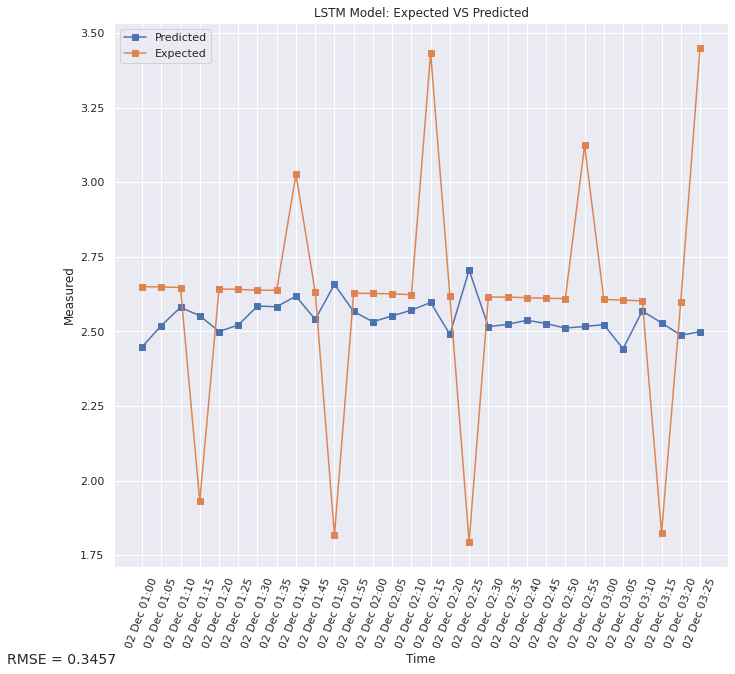

In [23]:
# Plot [start, end] interval
## 0 ~ 11824
start = 300
end = 330
plot_predicted_vs_expected(results["predicted"], results["expected"], results["overall_score"], data.index, start, end)

## Scatter Plot

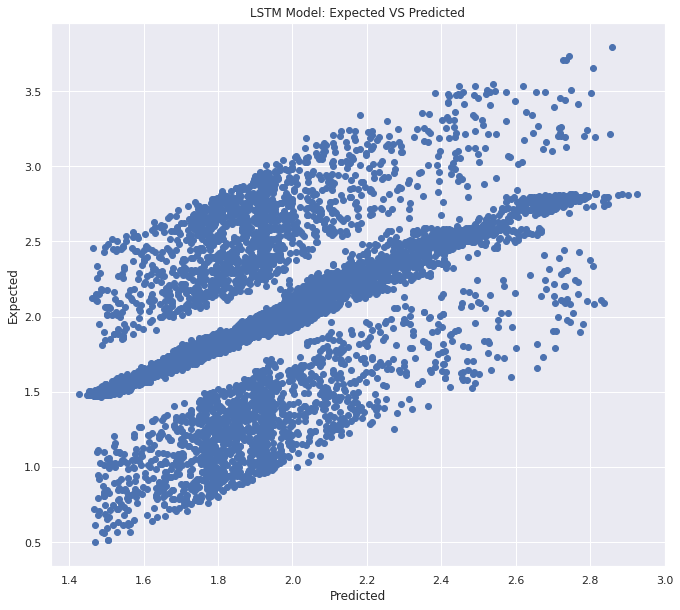

In [24]:
start = 0
end = -1
scatter_plot(results["predicted"], results["expected"], start, end)

## Main - Classification

### 1) Spikes | S


Limit: 0.1165

Spike (S):

  General:
    - TP: 2941
    - TN: 6631
    - FP: 1
    - FN: 2251
    - Hits: 9572
    - Misses: 2252
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 80.95%
    - Precision: 99.97%
    - Recall: 56.64%
    - F1-Score: 72.31%


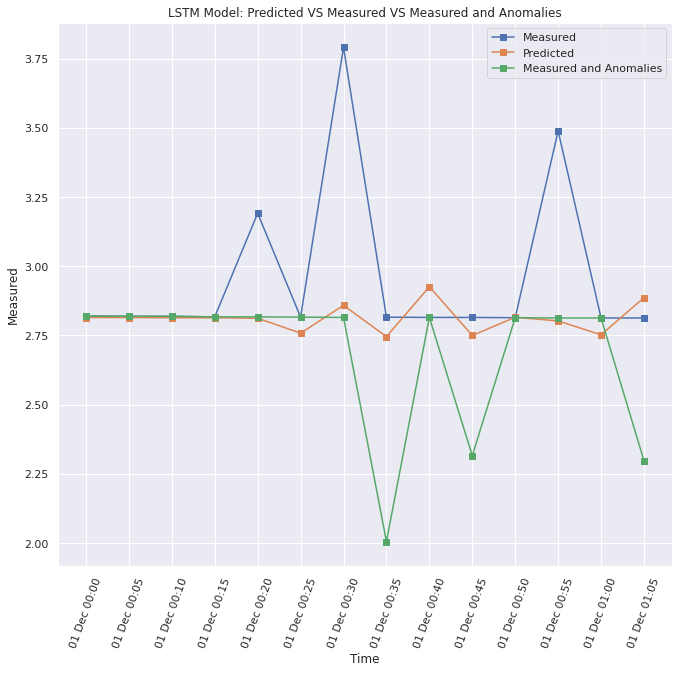

In [25]:
# Read "Spike" data
anomaly_type = "s"
s_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

### 2) Stationary Values | SV


Limit: 0.1165

Stationary Value (SV):

  General:
    - TP: 1
    - TN: 7006
    - FP: 2
    - FN: 4815
    - Hits: 7007
    - Misses: 4817
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 59.26%
    - Precision: 33.33%
    - Recall: 0.02076%
    - F1-Score: 0.0415%


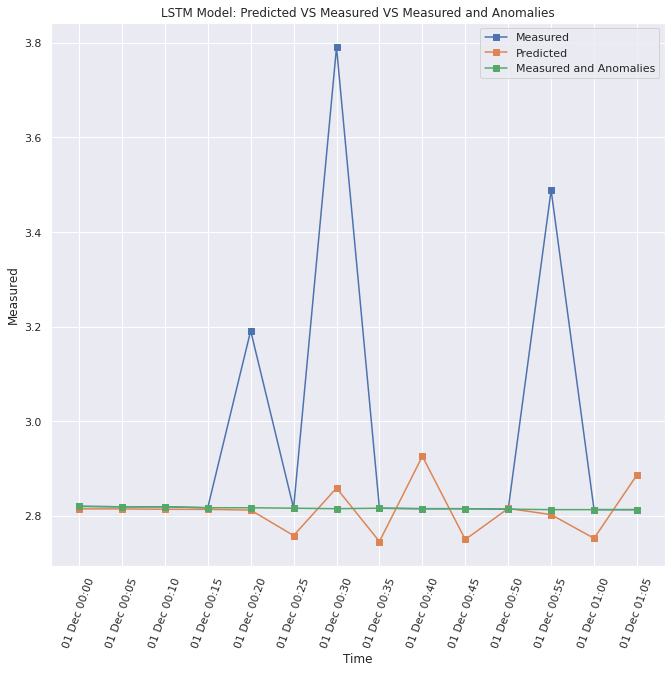

In [26]:
# Read "Stationary Values" data
anomaly_type = "sv"
sv_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sv_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

### 3) Sensor Displacement | SD


Limit: 0.1165

Sensor Displacement (SD):

  General:
    - TP: 2794
    - TN: 6649
    - FP: 1
    - FN: 2380
    - Hits: 9443
    - Misses: 2381
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 79.86%
    - Precision: 99.96%
    - Recall: 54.0%
    - F1-Score: 70.12%


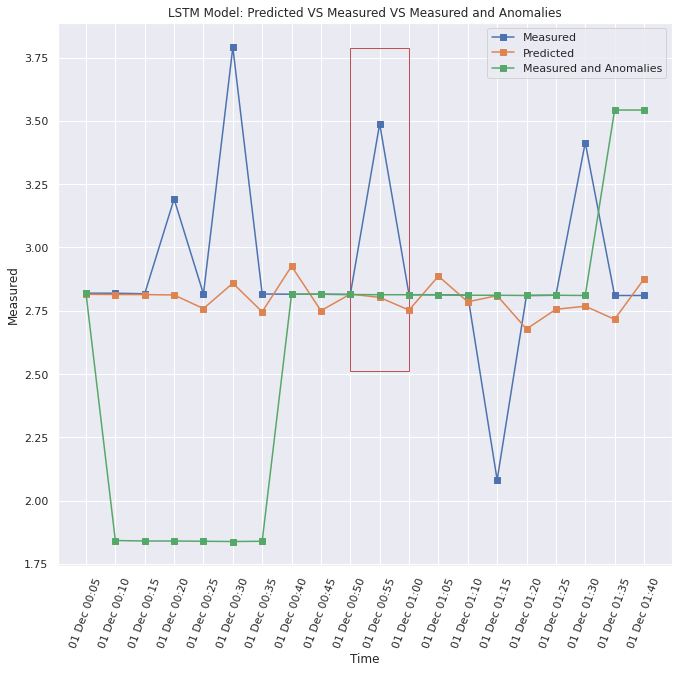

In [27]:
# Read "Sensor Displacement" data
anomaly_type = "sd"
sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 4) S + SV


Limit: 0.1165

Spike (S) and Stationary Value (SV):

  General:
    - TP: 442
    - TN: 6912
    - FP: 1
    - FN: 4469
    - Hits: 7354
    - Misses: 4470
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 62.2%
    - Precision: 99.77%
    - Recall: 9.0%
    - F1-Score: 16.51%


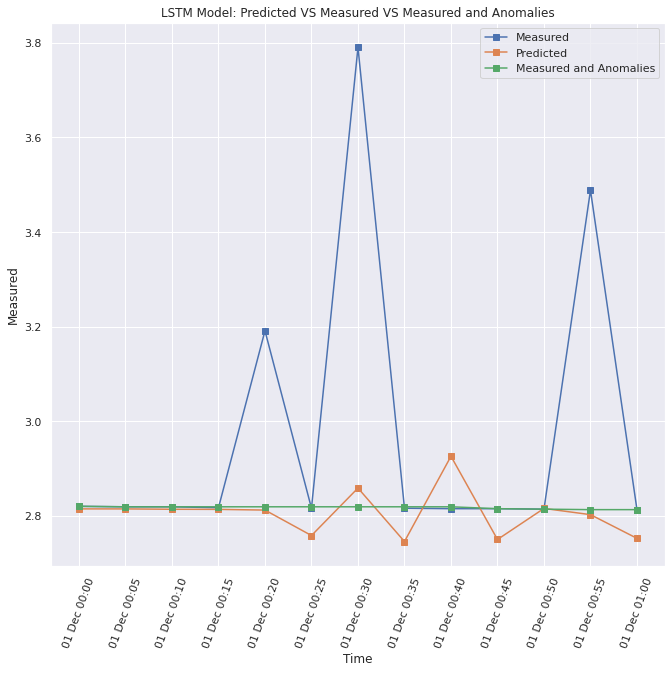

In [28]:
# Read "Spike + Stationary Values" data
anomaly_type = "s+sv"
s_sv_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sv_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 5) S + SD


Limit: 0.1165

Spike (S) and Sensor Displacement (SD):

  General:
    - TP: 2844
    - TN: 6605
    - FP: 3
    - FN: 2372
    - Hits: 9449
    - Misses: 2375
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 79.91%
    - Precision: 99.89%
    - Recall: 54.52%
    - F1-Score: 70.54%


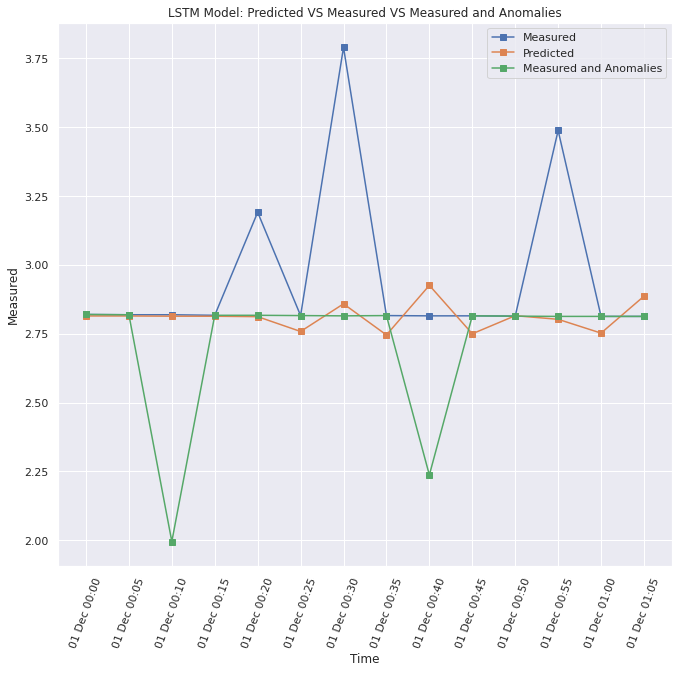

In [29]:
# Read "Spike + Sensor Displacement" data
anomaly_type = "s+sd"
s_sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 6) SV + SD


Limit: 0.1165

Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 1535
    - TN: 6761
    - FP: 3
    - FN: 3525
    - Hits: 8296
    - Misses: 3528
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 70.16%
    - Precision: 99.8%
    - Recall: 30.34%
    - F1-Score: 46.53%


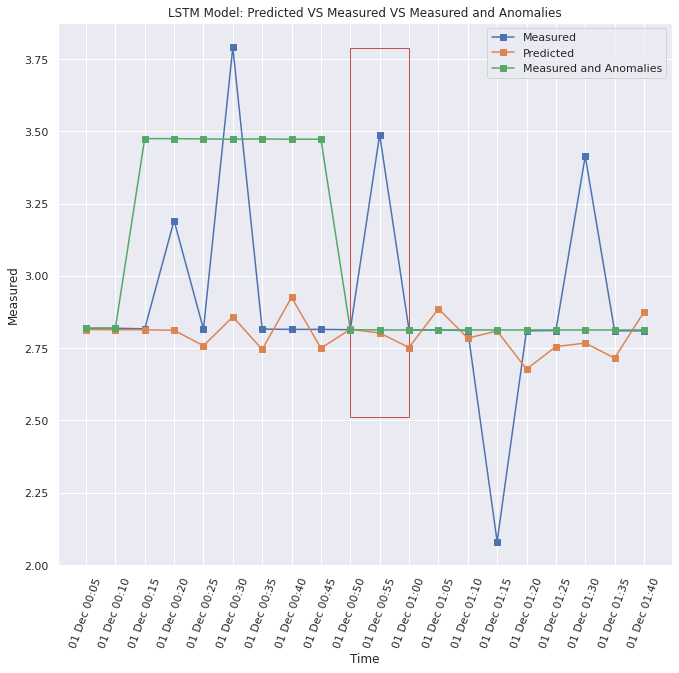

In [30]:
# Read "Stationary Values + Sensor Displacement" data
anomaly_type = "sv+sd"
sv_sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], sv_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = np.mean(np.abs((results["expected"] - results["predicted"]) / results["expected"]))

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)

## 7) S + SV + SD


Limit: 0.1165

Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 1447
    - TN: 6817
    - FP: 2
    - FN: 3558
    - Hits: 8264
    - Misses: 3560
    - Total (hits + misses): 11824

  Metrics:
    - Accuracy: 69.89%
    - Precision: 99.86%
    - Recall: 28.91%
    - F1-Score: 44.84%


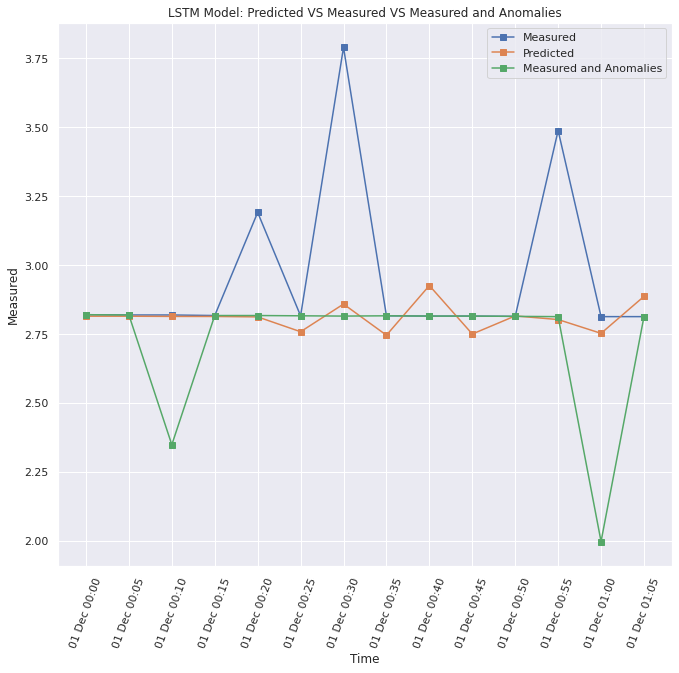

In [31]:
# Read "Spike + Stationary Values + Sensor Displacement" data
anomaly_type = "s+sv+sd"
s_sv_sd_data = read_anomaly_data("./csvs/test_set", anomaly_type)

# Create and init the classifier
clf = Classifier()
clf.init()
clf.get_mav_data(results["predicted"], s_sv_sd_data)
clf.get_expected_classes(results["expected"])

# Calculates the MAPE
mape = np.mean(np.abs((results["expected"] - results["predicted"]) / results["expected"]))

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
clf.get_classification(results["predicted"], limit)
clf.get_metrics(anomaly_type)

# Shows in which anomaly the classifier missed
clf.show_the_wrongs_predictions(results["predicted"], results["expected"], data.index, 0, anomaly_type)